`CMPE-255. Fall 2023`

**Submitted By**: Darshini Venkatesha Murthy Nag <br/>
**SJSU ID**: 016668951 <br/>

# The Traveling Salesman

Larry, a traveling salesman with Cheapsales, Inc., spends 365 (366 on leap years) days a year on the road, visiting the entire USA.

Bigspender, Inc. acquires Cheapsales. They are committed to bringing more resources into the sales organization. Larry, initially hopeful that his traveling days may be reduced, turns skeptical when his new manager states the conditions to hire more traveling salesmen:

“We shall hire the minimal number of salesman needed to cover all locations without the need for expensive air traveling”.



## The Data

| Item | Value | Notes |
| ---- | ---- | ---- |
| Locations to visit every year |	4,000	| The total number of locations the sales team needs to visit every year |
| Maximum region to region travel |	150 miles |	The total number of miles a salesman can travel on a single day from one region to another |
| Maximum working days | 240 days |	The maximum number of days a salesman will work or travel each year |
| Number of visits per day |	7 visits |	Maximum number of visits a salesman can do on a single day |
| Location affiliation | 50% red, 50% blue | The political affiliation of each location |


## Assumptions

| Assumption |
| ---- |
| The USA is a rectangle of width = 2,680 miles and height = 1,582 miles |
| Locations in the USA are randomly distributed |
| In one working day, a salesman can either visit locations or travel, but not both |
| The travel time between locations when a salesman is "visiting" is not considered |
| In every "visiting" day a salesman can only visit locations of a single affiliation (either visit "red" locations or "blue" locations, but not both |


In [49]:
pip install prettytable

In [50]:
# Libraries. Add as needed
import numpy as np
import random
import matplotlib.pyplot as plt
import itertools
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import math
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from prettytable import PrettyTable

In [51]:
# DO NOT MODIFY
SALES_LOCATIONS = 4000

MAP_WIDTH = 2680
MAP_HEIGHT = 1582

MAX_VISITS_PER_DAY = 7
MAX_TRAVEL_PER_DAY = 150
MAX_WORKING_DAYS = 240

# Utility Functions

The following utility functions can be used (or not) during the resolution of the homework. They are provided here for convenience.

In [52]:
# DO NOT MODIFY
def create_sales_map(no_locations=SALES_LOCATIONS, map_width=MAP_WIDTH, map_height=MAP_HEIGHT, mode='random'):
  '''Function to randomly create locations and location affiliations on a square map'''

  if mode == 'random':
    locs_x = np.random.randint(map_width, size=(no_locations,1))
    locs_y = np.random.randint(map_height, size=(no_locations,1))
    #locs = np.dstack((locs_x, locs_y))[0]
    locs  = np.concatenate((locs_x, locs_y), axis=1)

  elif mode == 'blobs':
    locs, _ = make_blobs(n_samples=no_locations, n_features=2, centers=int(no_locations/50))
    minXY = np.min(locs, axis=0)
    maxXY = np.max(locs, axis=0)
    rangeXY = np.subtract(maxXY, minXY)
    ratioXY = np.divide(np.array((map_width, map_height)), rangeXY)
    s_locs = np.add(np.absolute(np.repeat([minXY], no_locations, axis=0)), locs)
    n_locs = np.multiply(ratioXY, s_locs)
    locs = n_locs.astype(int)

  else:
    print("ERROR: Unsupported mode: ", mode)
    return None, None

  # Normal distribution for affiliations: 50% red (0), 50% blue (1)
  affiliation = np.random.randint(2, size=no_locations)

  return locs, affiliation


def plot_clusters(clusters, centroids=None):
  '''Plot clusters and centroids in different colors
     clusters: Dictionary of lists. Each key is the ID of a cluster.
     centroids: List of locations'''
  colors = itertools.cycle(["green", "blue", "magenta", "yellow", "white",
                            "black", "grey", "violet", "pink", "turquoise",
                            "cyan", "purple", "orange", "olive", "brown"])
  plt.xlabel('X (miles)')
  plt.ylabel('Y (miles)')
  plt.title('Locations in a rectangular US map')
  for key in range(len(clusters.keys())):
    if len(clusters[key]) == 0:
      continue
    plt.scatter(*zip(*clusters[key]), color=next(colors), marker=".")

  if centroids is not None and centroids.any():
    plt.scatter(*zip(*centroids), color="red", marker='^')


def plot_locations(locations, color="blue"):
  plt.xlabel('X (miles)')
  plt.ylabel('Y (miles)')
  plt.title('Locations in a rectangular US map')
  plt.scatter(*zip(*locations), color=color, marker='D')


In [53]:
# Create a sales map with 4000 locations
random_map, random_affiliations = create_sales_map(no_locations=4000, mode='random')
blobs_map, blobs_affiliations = create_sales_map(no_locations=4000, mode='blobs')

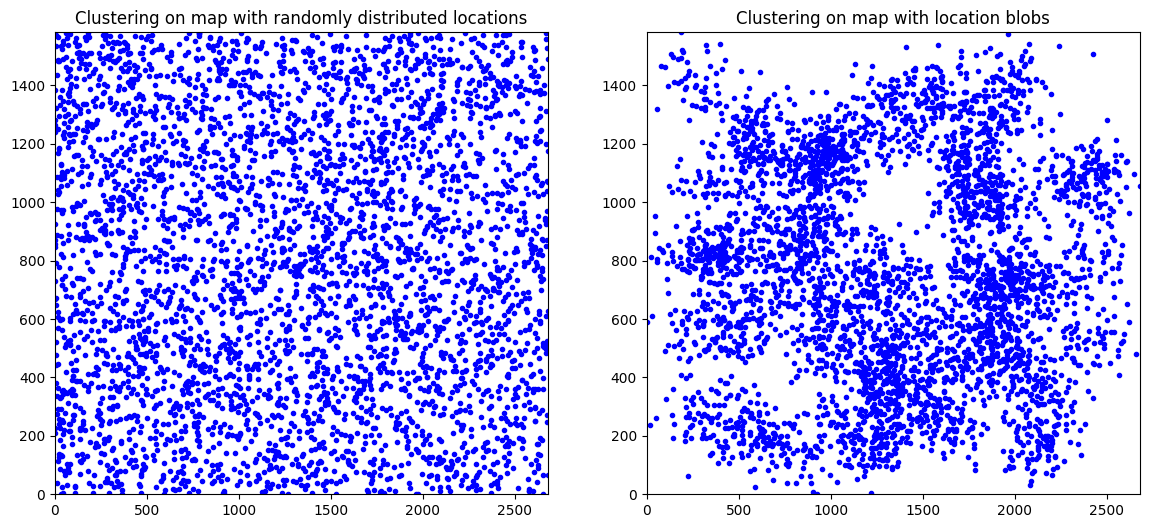

In [54]:
# DISPLAY
fig = plt.figure(1, (14, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

# PLOT Locations, then Centroids on top
ax1.scatter(*zip(*random_map), color='blue', marker=".")
ax2.scatter(*zip(*blobs_map), color='blue', marker=".")

ax1.set_ylim(0, MAP_HEIGHT)
ax1.set_xlim(0, MAP_WIDTH)
ax1.set_title("Clustering on map with randomly distributed locations")
ax2.set_ylim(0, MAP_HEIGHT)
ax2.set_xlim(0, MAP_WIDTH)
ax2.set_title("Clustering on map with location blobs")
plt.show()

# 1. Clustering without Affiliation

For this deliverable ignore the "affiliation" information.

* a) Using the scikit-learn package, cluster locations to meet the requirements of the homework (except affiliation)
* b) Describe the strategy and reasons behind it
* c) Create clusters for two maps: one generated using 'random' mode, and the second using the 'blobs' mode

a) I have simulated 4,000 locations within the given dimensions of the USA (2680 miles by 1582 miles). For clustering, I have used the KMeans Clustering Algorithm from scikit-learn, as i think it's suitable for the given problem. I have created two sets of cluster maps without affiliation: one using random mode and another using blob mode.

b) **Strategy**


*  **Utilization of the Elbow Method**  
This technique is chosen for identifying the ideal number of clusters, balancing between the quantity of clusters and the variance they explain. It's effective in determining how to group locations in an optimal way.

* **Initial Clustering**  


1. Calculate the initial number of clusters from the total sales locations (SALES_LOCATIONS) and the maximum daily visits a salesman can make in a day(MAX_VISITS_PER_DAY).
2. Apply the K-means algorithm (KMeans) for clustering.

* **Adjusting Clusters**


1. Start with initial clusters, sales locations, and the constraints MAX_VISITS_PER_DAY and MAX_TRAVEL_PER_DAY.
2. Measure Euclidean distances between location pairs.
3. Iterate through each initial cluster, adding locations to a new potential refined cluster without breaching the travel distance limit.
4. Finalize a potential cluster when it reaches MAX_VISITS_PER_DAY, then proceed to create the next one.
5. This process results in refined clusters that adhere to visit and travel constraints.

* **Calculating Minimum Salesmen**


1. Determine the minimum number of salesmen needed, based on the number of refined clusters and the maximum working days (MAX_WORKING_DAYS).
2. This step assigns each salesman a specific number of clusters to manage within the allotted working days.


*  **Final Clustering**

  Apply K-means to the sales locations, setting the number of clusters equal to the calculated minimum number of salesmen.


**Reasons**


*   This strategy combines the initial spatial clustering capabilities of K-means with a refinement process to ensure each cluster meets specific business constraints.
*   It efficiently groups sales locations initially and then fine-tunes these groups to align with real-world limitations on visits and travel distances.
*   The approach is both practical and optimized, leveraging automated initial grouping and a detailed refinement process for operational feasibility.



c) Implementation of Clusters is as shown below

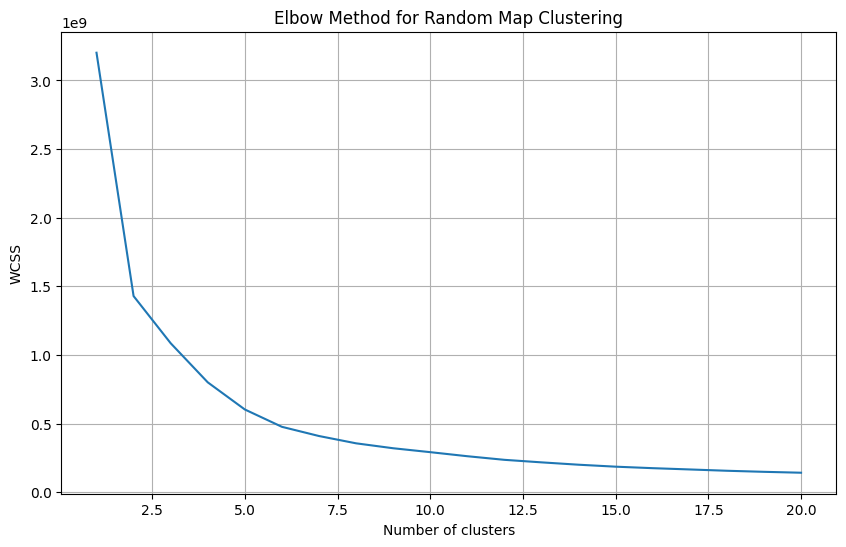

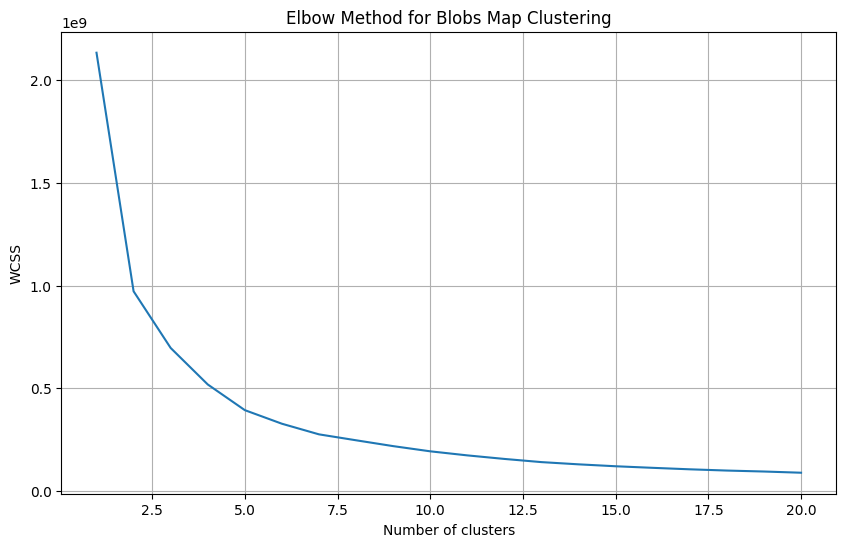

In [55]:
def calculate_wcss(data):
  return [KMeans(n_clusters=n, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(data).inertia_
          for n in range(1, 21)]

# Calculate WCSS for 'random' and 'blobs' maps
wcss_random = calculate_wcss(random_map)
wcss_blobs = calculate_wcss(blobs_map)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), wcss_random)
plt.title('Elbow Method for Random Map Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), wcss_blobs)
plt.title('Elbow Method for Blobs Map Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()


From the above elbow method we can determine that the optimal k value range lies between 3 to 5. I have picked k=4.

In [56]:
def check_travel_constraint(existing_cluster, candidate_location, distances, max_distance):
    """
    Verify if including a new location in a cluster does not exceed the travel limit.
    """
    return all(distances[loc, candidate_location] <= max_distance for loc in existing_cluster)

def compute_pairwise_distances(locations):
    """
    Compute the Euclidean distance between each pair of locations.
    """
    return cdist(locations, locations, 'euclidean')

def optimize_clusters(initial_cluster_labels, locations, max_locations_per_day, max_daily_travel):
    """
    Optimize the initial clusters to adhere to visit and travel limitations.
    """
    pairwise_distances = compute_pairwise_distances(locations)
    optimized_clusters = {}
    cluster_index = 0

    for cluster_label in set(initial_cluster_labels):
        cluster_members = np.where(initial_cluster_labels == cluster_label)[0]
        temp_cluster = []

        for member in cluster_members:
            if len(temp_cluster) < max_locations_per_day and check_travel_constraint(temp_cluster, member, pairwise_distances, max_daily_travel):
                temp_cluster.append(member)

            if len(temp_cluster) == max_locations_per_day:
                optimized_clusters[cluster_index] = temp_cluster
                cluster_index += 1
                temp_cluster = []

        if temp_cluster:
            optimized_clusters[cluster_index] = temp_cluster
            cluster_index += 1

    return optimized_clusters

In [57]:
def initial_clustering(data, max_visits_per_day):
    num_clusters = math.ceil(len(data) / max_visits_per_day)
    kmeans_model = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)
    return kmeans_model.fit_predict(data)

def calculate_minimum_salesmen(refined_cluster_count, max_working_days):
    return math.ceil(refined_cluster_count / max_working_days)

def cluster_dict(cluster_labels, data):
    clusters = {}
    for idx, label in enumerate(cluster_labels):
        clusters.setdefault(label, []).append(data[idx])
    return clusters

In [58]:
# Random Map
# Initial Clustering
initial_clusters = initial_clustering(random_map, MAX_VISITS_PER_DAY)

# Optimizing Clusters
optimized_clusters = optimize_clusters(initial_clusters, random_map, MAX_VISITS_PER_DAY, MAX_TRAVEL_PER_DAY)
num_optimized_clusters = len(set(optimized_clusters))

# Minimum number of employees required
minimum_employees = calculate_minimum_salesmen(num_optimized_clusters, MAX_WORKING_DAYS)

# Final Clustering for Employee Allocation
kmeans1 = KMeans(n_clusters=minimum_employees,n_init=10, random_state=0).fit(random_map)
random_final_clusters = kmeans1.labels_

# Creating a Dictionary for Cluster Representation
optimized_clusters_dict = cluster_dict(random_final_clusters, random_map)

print(f"Minimum number of salesmen required - Rand Map: {minimum_employees}")

Minimum number of salesmen required - Rand Map: 4


In [59]:
# Blob Map
# Initial Clustering
initial_clusters_blob = initial_clustering(blobs_map, MAX_VISITS_PER_DAY)

# Optimizing Clusters
optimized_clusters_blob = optimize_clusters(initial_clusters_blob, blobs_map, MAX_VISITS_PER_DAY, MAX_TRAVEL_PER_DAY)
num_optimized_clusters_blob = len(set(optimized_clusters_blob))

# Minimum number of employees required
min_employees = calculate_minimum_salesmen(num_optimized_clusters_blob, MAX_WORKING_DAYS)

# Final Clustering for Employee Allocation
kmeans2 = KMeans(n_clusters=min_employees,n_init=10, random_state=0).fit(blobs_map)
blob_final_clusters = kmeans2.labels_

# Creating a Dictionary for Cluster Representation
optimized_clusters_dict_blobs = cluster_dict(blob_final_clusters, blobs_map)

print(f"Minimum number of salesmen required - Blob Map: {min_employees}")

Minimum number of salesmen required - Blob Map: 4


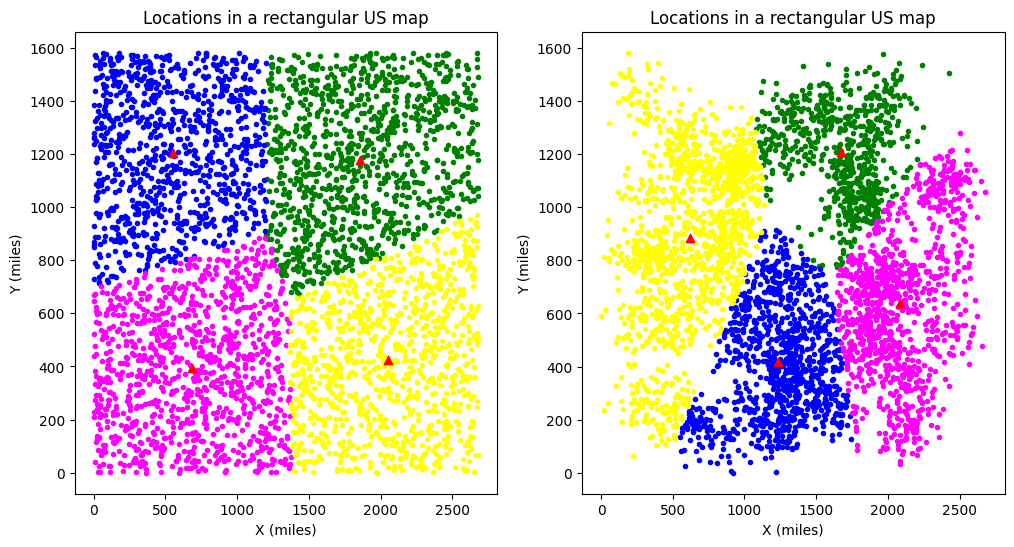

In [60]:
# Visualization of Clusters

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_clusters(optimized_clusters_dict, centroids=kmeans1.cluster_centers_)
plt.subplot(1, 2, 2)
plot_clusters(optimized_clusters_dict_blobs, centroids=kmeans2.cluster_centers_)
plt.show()

In the above, The first map shows clusters generated using random mode and the second map shows clusters generated using blobs mode.

# 2. Clustering with Affiliation

Considering the "affiliation" information.

* a) Cluster locations to meet the requirements of the homework (all requirements, including the "affiliation")
This clustering can be done either using scikit-learn functions, or creating a custom KMeans function. Either approach is acceptable.
* b) Describe the strategy and reasons behind it
* c) Create clusters for two maps: one generated using 'random' mode, and the second using the 'blobs' mode

a) I have simulated 4,000 locations within the given dimensions of the USA (2680 miles by 1582 miles). For clustering, I have used the KMeans Clustering Algorithm from scikit-learn, as i think it's suitable for the given problem case. I have created two sets of cluster maps with affiliation: one using random mode and another using blob mode.

b) **Strategy**

The aim of the clustering and sub-clustering approach is to effectively distribute the sales locations across the workforce, making certain that every salesperson's area complies with the established restrictions.

* **Initial Clustering Using K-Means**  
The process starts by segmenting the total pool of sales locations into distinct zones through k-means clustering. Each zone is then allocated to a specific salesperson, ensuring an initial distribution of sales territories.

* **Refinement through Sub-Clustering**  
The next step involves a more detailed segmentation within each salesperson's territory. This is based on the political leanings of the locations (categorized as red or blue). If a salesperson's territory has an excess number of locations of a particular political affiliation, exceeding the maximum daily visits, it undergoes further segmentation or sub-clustering.

* **Final Structure**  
The culmination of this process is represented in the structure (employee_territories_random), where each salesperson's territory is broken down into smaller clusters, each corresponding to red and blue political affiliations.  

In essence, this strategy aims to distribute sales locations equitably among employees, while respecting travel limits and visit capacities. It also ensures that each salesperson's territory is tailored considering political affiliations, using k-means for initial clustering and sub-clustering for detailed organization.


**Reasons**

* K-means clustering is utilized by the algorithm to automatically categorize sales locations into distinct groups based on their proximity.
* Allocating a single territory to each salesman guarantees a balanced distribution of both workload and geographical reach across the sales team.
* Further, sub-clustering ensures that the territory assigned to each salesman is composed of locations with similar political leanings.
* This sub-clustering is key for adhering to the rule that salesmen can only visit locations with the same political affiliation on any given day.
* This approach also streamlines travel distances and enhances the number of possible visits within the set boundaries.

c) Implementation of Clusters is as shown below

In [61]:
def calculate_total_distance(locations):
    # Calculate the total distance of a route visiting all locations in sequence
    if len(locations) > 1:
        # Create a matrix of distances between consecutive locations
        distances = cdist(locations[:-1], locations[1:], metric='euclidean')
        # Sum the distances to get the total distance
        total_distance = np.sum(distances)
    else:
        total_distance = 0

    return total_distance

def sub_cluster_by_affiliation(employee_territories, max_visits_per_day, max_travel_per_day):
    for territory_id, territory_data in employee_territories.items():
        for affiliation_color, affiliation_num in [('red', 0), ('blue', 1)]:
            locs = territory_data['locs'][territory_data['affiliations'] == affiliation_num]

            if len(locs) <= max_visits_per_day:
                # If the locations are fewer than the max visits per day, no need to cluster
                employee_territories[territory_id][f'{affiliation_color}_clusters'] = [locs]
            else:
                # Perform initial clustering
                kmeans = KMeans(n_clusters=math.ceil(len(locs) / max_visits_per_day), n_init=10, random_state=0).fit(locs)
                clusters = [locs[kmeans.labels_ == i] for i in range(kmeans.n_clusters)]

                # Adjust clusters to respect the max travel per day constraint
                adjusted_clusters = []
                for cluster in clusters:
                    # Split clusters if they exceed the max travel distance
                    if calculate_total_distance(cluster) > max_travel_per_day:
                        # simplistic approach and can be refined
                        # Split the cluster into smaller ones
                        sub_cluster_size = max_visits_per_day // 2  # split factor
                        for i in range(0, len(cluster), sub_cluster_size):
                            adjusted_clusters.append(cluster[i:i+sub_cluster_size])
                    else:
                        adjusted_clusters.append(cluster)

                employee_territories[territory_id][f'{affiliation_color}_clusters'] = adjusted_clusters


In [62]:
# Random Map Territory Assignment
num_of_territories = minimum_employees  # One territory per employee
kmeans_territories = KMeans(n_clusters=num_of_territories, n_init=10, random_state=0).fit(random_map)
territory_labels = kmeans_territories.labels_

employee_territories_random = {
    i: {'locs': random_map[territory_labels == i], 'affiliations': random_affiliations[territory_labels == i]}
    for i in range(num_of_territories)
}

# Perform sub-clustering on the random map
sub_cluster_by_affiliation(employee_territories_random, MAX_VISITS_PER_DAY, MAX_TRAVEL_PER_DAY)

In [63]:
# Blobs Map Territory Assignment
num_of_territories = min_employees  # One territory per employee
kmeans_territories = KMeans(n_clusters=num_of_territories, n_init=10, random_state=0).fit(blobs_map)
territory_labels = kmeans_territories.labels_

employee_territories_blobs = {
    i: {'locs': blobs_map[territory_labels == i], 'affiliations': blobs_affiliations[territory_labels == i]}
    for i in range(num_of_territories)
}

# Perform sub-clustering on the blobs map
sub_cluster_by_affiliation(employee_territories_blobs, MAX_VISITS_PER_DAY, MAX_TRAVEL_PER_DAY)


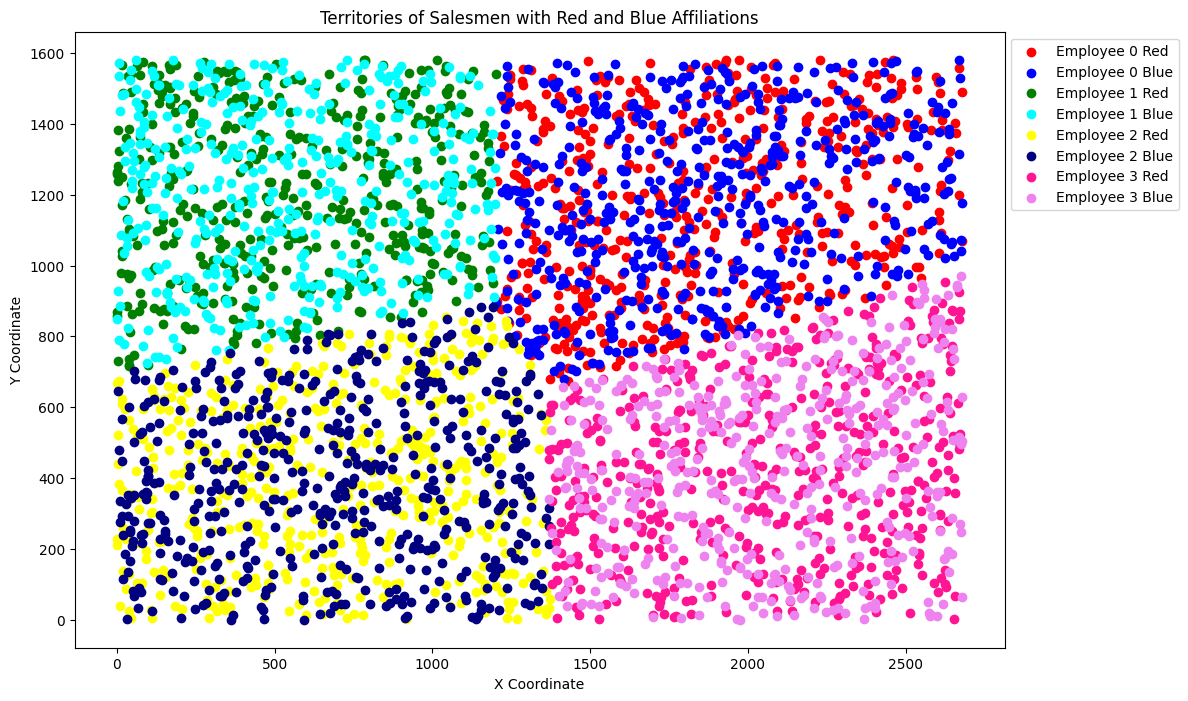

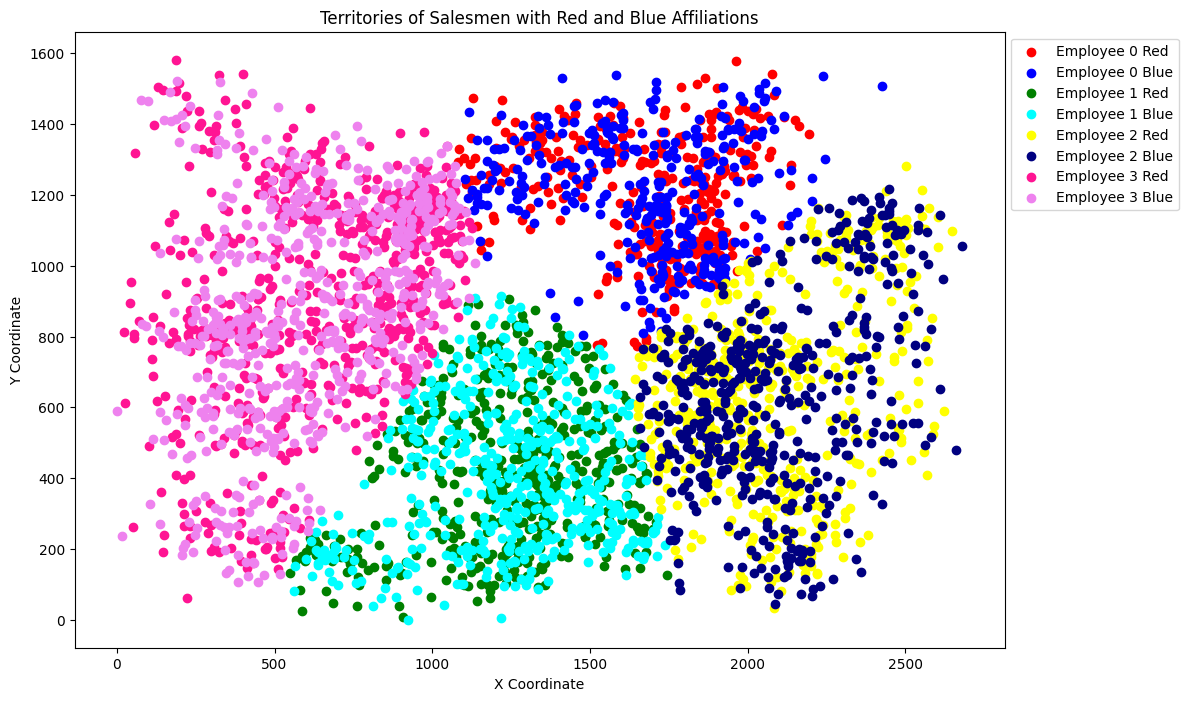

In [64]:
def plot_employee_territories_with_affiliations(salesmen_territories):
    plt.figure(figsize=(12, 8))
    red_palette, blue_palette =  ['red', 'green', 'yellow', 'deeppink'], ['blue', 'cyan', 'navy', 'violet']

    for salesman_number, territories in salesmen_territories.items():
        # Assign unique colors from palettes for each employee
        red_color, blue_color = red_palette[salesman_number % len(red_palette)], blue_palette[salesman_number % len(blue_palette)]

        # Plot red and blue sub-clusters for each employee
        for red_cluster in territories['red_clusters']:
            plt.scatter(red_cluster[:, 0], red_cluster[:, 1], color=red_color, label=f'Employee {salesman_number} Red' if red_cluster is territories['red_clusters'][0] else "")
        for blue_cluster in territories['blue_clusters']:
            plt.scatter(blue_cluster[:, 0], blue_cluster[:, 1], color=blue_color, label=f'Employee {salesman_number} Blue' if blue_cluster is territories['blue_clusters'][0] else "")

    plt.title('Territories of Salesmen with Red and Blue Affiliations')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    # Create a custom legend to avoid duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

# Plot for both datasets
plot_employee_territories_with_affiliations(employee_territories_random)
plot_employee_territories_with_affiliations(employee_territories_blobs)


In the above graphs, first graph represents Territories of salesmen with red and blue affiliations created using random mode, second graph represents Territories of salesmen with red and blue affiliations created using blobs mode.

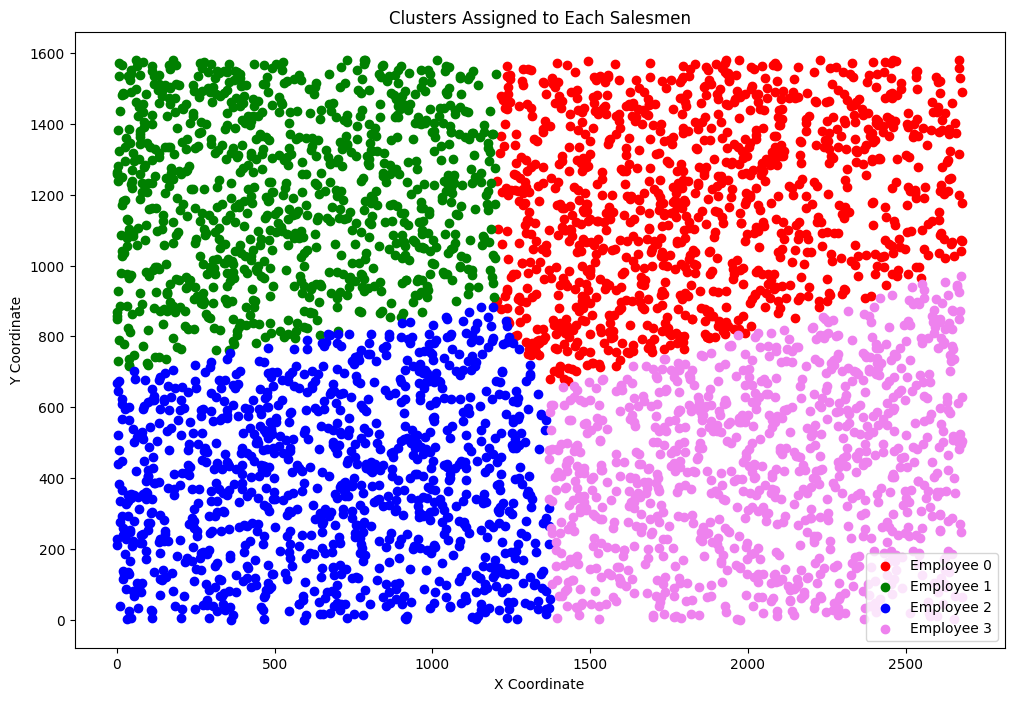

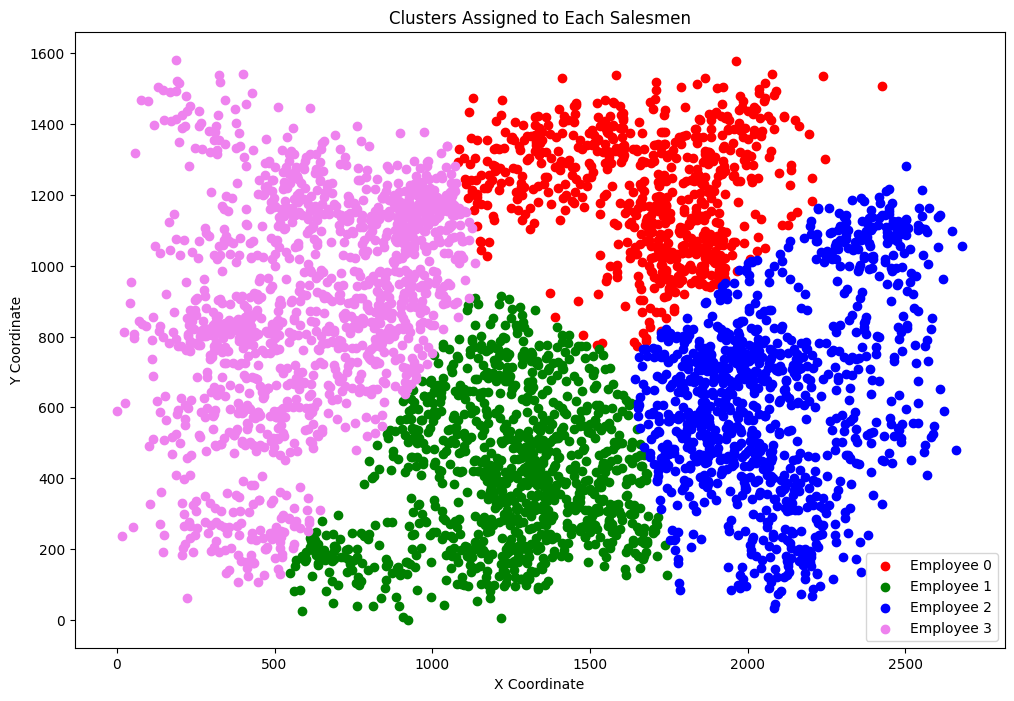

In [65]:
def plot_employee_clusters(salesmen_territories):
    plt.figure(figsize=(12, 8))
    color_palette = ['red', 'green', 'blue', 'violet', 'orange', 'cyan', 'magenta', 'purple']

    for salesman_number, territories in salesmen_territories.items():
        # Use a distinct color for each employee
        employee_color = color_palette[salesman_number % len(color_palette)]

        # Combine and plot both red and blue clusters for each employee
        for cluster in territories['red_clusters'] + territories['blue_clusters']:
            plt.scatter(cluster[:, 0], cluster[:, 1], color=employee_color, label=f'Employee {salesman_number}' if cluster is territories['red_clusters'][0] else "")

    plt.title('Clusters Assigned to Each Salesmen')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    # Creating a legend without duplicate labels
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

# Plot for both datasets
plot_employee_clusters(employee_territories_random)
plot_employee_clusters(employee_territories_blobs)


In the above graphs, first graph represents the Clusters assigned to each salesmen created using random mode, second graph represents the clusters assigned to each salesmen created using blobs mode.

# 3. Quality of the clustering

* a) Select and describe at least one quality measure for the clusters.
* b) Apply the quality measure to the clustered data from deliverables 1 and 2. Display the results. There should be four results, one for each of the clusters created in 1 and 2.

a) I have chosen Silhouette score Metric for measuring the quality of clusters. <br/>  
The silhouette score is a measure used to evaluate the quality of clusters in a dataset. It gauges how similar an object is to its own cluster compared to other clusters. The value of the silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

b) The silhouette score metric is applied to clustered data from deliverables 1 and 2 and results are displayed as shown below.

In [66]:
silhouette_score_random = silhouette_score(random_map, random_final_clusters)
print(f"Silhouette Score for clusters created with Random Map as part of Deliverable 1: {silhouette_score_random}")

silhouette_score_blob = silhouette_score(blobs_map, blob_final_clusters)
print(f"Silhouette Score for clusters created with Blobs Map as part of Deliverable 1: {silhouette_score_blob}")

Silhouette Score for clusters created with Random Map as part of Deliverable 1: 0.36881972360262455
Silhouette Score for clusters created with Blobs Map as part of Deliverable 1: 0.40496938324272197


In [67]:
def combine_redblue_clusters(salesmen_territories):
    combined_redblue_clusters = []

    for territory_id, territory_data in salesmen_territories.items():
        # Combine both red and blue clusters for each territory
        red_clusters = territory_data['red_clusters']
        blue_clusters = territory_data['blue_clusters']

        combined_redblue_clusters.extend(red_clusters + blue_clusters)

    return combined_redblue_clusters

# Combine clusters for both random and blobs maps
random_combined_clusters = combine_redblue_clusters(employee_territories_random)
blob_combined_clusters = combine_redblue_clusters(employee_territories_blobs)

# Get cluster labels for each point
labels_random = np.concatenate([np.full(len(cluster), i) for i, cluster in enumerate(random_combined_clusters)])
labels_blob = np.concatenate([np.full(len(cluster), i) for i, cluster in enumerate(blob_combined_clusters)])

# Calculate silhouette score
silhouette_random = silhouette_score(random_map, labels_random)
silhouette_blob = silhouette_score(blobs_map, labels_blob)

print(f"Silhouette Score for clusters created with Random Map as part of Deliverable 2: {silhouette_random}")
print(f"Silhouette Score for clusters created with Blobs Map as part of Deliverable 2: {silhouette_blob}")

Silhouette Score for clusters created with Random Map as part of Deliverable 2: -0.8759355433558791
Silhouette Score for clusters created with Blobs Map as part of Deliverable 2: -0.8759287451969426


# 4. Answer to the main question: How many salesman are needed

* a) Based on the data and assumptions, calculate how many salesmen are needed to meet all constraints. Provide the number for the 4 clusters done in deliverables 1 and 2.
* b) Explain what assumptions (beyond the ones already provided above) are made to reach the numbers in 4.a. You are at liberty to apply any additional assumptions you want, specially if they make the analysis easier.
* c) Provide a table of "Average work load for all salesmen", for each case.

a) The number of salesmen required to meet all constraints is as shown below

In [68]:
# Deliverable 1 - Cluster without Affiliation

no_of_salesmen_random = minimum_employees
no_of_salesmen_blobs = min_employees

print(f"Number of Salesmen Needed - Random Map: {no_of_salesmen_random}")
print(f"Number of Salesmen Needed - Blobs Map: {no_of_salesmen_blobs}")

Number of Salesmen Needed - Random Map: 4
Number of Salesmen Needed - Blobs Map: 4


In [69]:
# Deliverable 2 - Cluster with Affiliation

no_of_salesmen_random_affiliation = len(employee_territories_random)
no_of_salesmen_blobs_affiliation = len(employee_territories_blobs)

print(f"Number of Salesmen Needed with affiliation - Random Map : {no_of_salesmen_random_affiliation}")
print(f"Number of Salesmen Needed with affiliation - Blobs Map : {no_of_salesmen_blobs_affiliation}")

Number of Salesmen Needed with affiliation - Random Map : 4
Number of Salesmen Needed with affiliation - Blobs Map : 4


b) **Assumptions**  
The calculations operate on the premise that every employee is allocated a specific territory, and these territories are arranged in a way that aligns with the constraints of travel and visitation. To find the least number of salesmen required, divide the complete count of optimized clusters by the maximum number of working days.

c) **Table of "Average work load for all salesmen"**

In [70]:
def assemble_Regions_From_Partitions(locations, cluster_assignments):
    salesmen_territories = {}
    for location, cluster_id in zip(locations, cluster_assignments):
        salesmen_territories.setdefault(cluster_id, {'locs': []})['locs'].append(location)
    return salesmen_territories

def calculate_individual_workload(locations, max_visits_per_day):
    return {
        'total_locations': len(locations),
        'working_days': math.ceil(len(locations) / max_visits_per_day)
    }

def calculate_average_and_workload(salesmen_territories, max_visits_per_day):
    workload_per_employee = {
        employee_id: calculate_individual_workload(data['locs'], max_visits_per_day)
        for employee_id, data in salesmen_territories.items()
    }
    total_working_days = sum(emp['working_days'] for emp in workload_per_employee.values())
    average_working_days = total_working_days / len(workload_per_employee) if workload_per_employee else 0
    return workload_per_employee, average_working_days

def display_workload_table_with_average(workload, average, title):
    table = PrettyTable()
    table.title = title
    table.field_names = ["Salesmen Number", "Total Locations", "Working Days"]
    table.align = "l"  # Align text to the left

    for employee_id, data in workload.items():
        table.add_row([employee_id, data['total_locations'], data['working_days']])

    print(table)
    print(f"{'Average Working Days':<17} : {average:.2f}\n")


random_without_affiliation = assemble_Regions_From_Partitions(random_map, random_final_clusters)
blob_without_affiliation = assemble_Regions_From_Partitions(blobs_map, blob_final_clusters)

workload_random_per_salesman, average_random = calculate_average_and_workload(random_without_affiliation, MAX_VISITS_PER_DAY)
workload_blobs_per_salesman, average_blobs = calculate_average_and_workload(blob_without_affiliation, MAX_VISITS_PER_DAY)

display_workload_table_with_average(workload_random_per_salesman, average_random, "Workload without affiliation - Random")
display_workload_table_with_average(workload_blobs_per_salesman, average_blobs, "Workload without affiliation - Blob")

+--------------------------------------------------+
|      Workload without affiliation - Random       |
+-----------------+-----------------+--------------+
| Salesmen Number | Total Locations | Working Days |
+-----------------+-----------------+--------------+
| 0               | 1081            | 155          |
| 1               | 907             | 130          |
| 3               | 975             | 140          |
| 2               | 1037            | 149          |
+-----------------+-----------------+--------------+
Average Working Days : 143.50

+--------------------------------------------------+
|       Workload without affiliation - Blob        |
+-----------------+-----------------+--------------+
| Salesmen Number | Total Locations | Working Days |
+-----------------+-----------------+--------------+
| 3               | 1286            | 184          |
| 2               | 1026            | 147          |
| 1               | 1010            | 145          |
| 0            

In [71]:
def calculate_workload_and_average_with_affiliation(salesmen_territories, max_visits_per_day):
    workload_per_salesman = {}
    total_working_days = 0

    for salesman_number, territories in salesmen_territories.items():
        num_locations = sum(len(cluster) for cluster in territories['red_clusters'] + territories['blue_clusters'])
        num_days = math.ceil(num_locations / max_visits_per_day)
        workload_per_salesman[salesman_number] = {'total_locations': num_locations, 'working_days': num_days}
        total_working_days += num_days

    average_working_days = total_working_days / len(workload_per_salesman) if workload_per_salesman else 0
    return workload_per_salesman, average_working_days

workload_random_per_salesman_with_affiliation, average_random_with_affiliation = calculate_average_and_workload(random_without_affiliation, MAX_VISITS_PER_DAY)
workload_blobs_per_salesman_with_affiliation, average_blobs_with_affiliation = calculate_average_and_workload(blob_without_affiliation, MAX_VISITS_PER_DAY)

display_workload_table_with_average(workload_random_per_salesman_with_affiliation, average_random_with_affiliation, "Workload with affiliation - Random")
display_workload_table_with_average(workload_blobs_per_salesman_with_affiliation, average_blobs_with_affiliation, "Workload with affiliation - Blob")

+--------------------------------------------------+
|        Workload with affiliation - Random        |
+-----------------+-----------------+--------------+
| Salesmen Number | Total Locations | Working Days |
+-----------------+-----------------+--------------+
| 0               | 1081            | 155          |
| 1               | 907             | 130          |
| 3               | 975             | 140          |
| 2               | 1037            | 149          |
+-----------------+-----------------+--------------+
Average Working Days : 143.50

+--------------------------------------------------+
|         Workload with affiliation - Blob         |
+-----------------+-----------------+--------------+
| Salesmen Number | Total Locations | Working Days |
+-----------------+-----------------+--------------+
| 3               | 1286            | 184          |
| 2               | 1026            | 147          |
| 1               | 1010            | 145          |
| 0            

# 5. Anomaly Detection
Consider only the 'blobs' map in deliverable 1.
* a) Using the scikit-learn functions, identify anomalies in the map locations.
The definition of an anomaly in this example would be: "Isolated locations, i.e., locations farther than 75 miles of any locations, and with at most 3 locations closer than 125 miles"
* b) Display a map with all locations in grey color, and the anomalies in red color

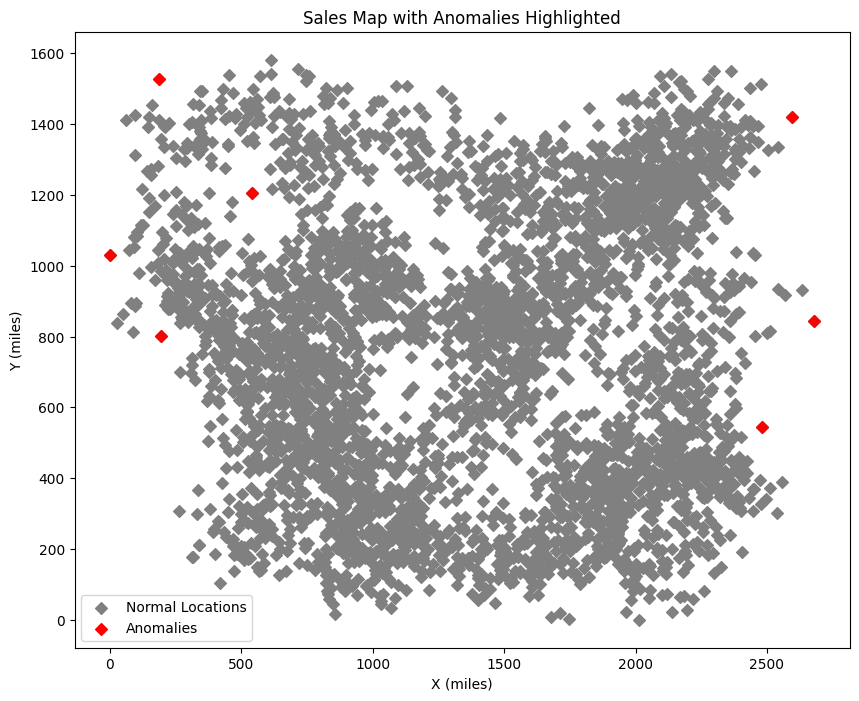

In [72]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs

# Create sales map with 'blobs' mode
locations, _ = create_sales_map(mode='blobs')

# DBSCAN for anomaly detection with 125 miles criteria
dbscan = DBSCAN(eps=125, min_samples=4)
clusters = dbscan.fit_predict(locations)

# Potential anomalies are locations with sparse clustering or no cluster
potential_anomalies = np.where((clusters == -1) | (np.bincount(clusters + 1)[clusters] <= 4))[0]

# Nearest neighbors for distance check
nearest_neighbors = NearestNeighbors(n_neighbors=2)  # Nearest neighbor excluding itself
nearest_neighbors.fit(locations)
distances, _ = nearest_neighbors.kneighbors(locations)

# Anomalies based on both conditions
anomalies = [i for i in potential_anomalies if distances[i, 1] > 75]

# Extracting anomaly locations
anomaly_locations = locations[anomalies]

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(locations[:, 0], locations[:, 1], color='grey', marker='D', label='Normal Locations')
plt.scatter(anomaly_locations[:, 0], anomaly_locations[:, 1], color='red', marker='D', label='Anomalies')
plt.xlabel('X (miles)')
plt.ylabel('Y (miles)')
plt.title('Sales Map with Anomalies Highlighted')
plt.legend()
plt.show()



In the code above, the DBSCAN algorithm first identifies clusters with eps=125. Then, potential anomalies are those points that are not in any dense cluster. Among these potential anomalies, those that are more than 75 miles away from their nearest neighbor are marked as true anomalies.